In [28]:
from pymemcache.client import base
import json

In [29]:

class AccelerometerStream():
    def __init__(self):
        self.memclient = base.Client(("localhost", 11211))
        self.stream = []
        
        self.events = []
        
        

    def get_stream_data(self,num,prefix = ""):
        """
        Given num number of entries return num entries from
        the memcached cache.
        "prefix" is added for gyro data (="g") instead of plain accel data
        Returns a list of json objects that contain each axis of data.
        eg {"x":0.123,"y":0.135,"z":0.321}
        
        """
        current_str = self.memclient.get("current")
        current = (int(current_str))
        ret = []
        for i in range(current-num,current):
            ret.append(json.loads(self.memclient.get(f"{prefix}{i}")))
        return ret
        
    

In [64]:
acc = AccelerometerStream()

In [65]:
strm = acc.get_stream_data(500,"g")


In [33]:
sstrm = acc.get_stream_data(500,"g")

In [66]:
strm[20:25]

[{'x': 32767, 'y': -7920, 'z': 2449, 'time': '2022-06-19T06:36:21.428963'},
 {'x': 32767, 'y': -7974, 'z': 2600, 'time': '2022-06-19T06:36:21.434963'},
 {'x': 32767, 'y': -7918, 'z': 2789, 'time': '2022-06-19T06:36:21.440945'},
 {'x': 32767, 'y': -7928, 'z': 2918, 'time': '2022-06-19T06:36:21.446933'},
 {'x': 32767, 'y': -7333, 'z': 2909, 'time': '2022-06-19T06:36:21.452962'}]

In [44]:

def get_events(strm,depth,dim):
    
    if depth > len(strm):
        raise ValueError("Depth value cannot be greater then the length of the stream")
    if dim not in ['x','y','z']:
        raise ValueError("Dimension must be x, y, or z")

    threshhold = 0.5
    state = "flat"
    state_set ={"flat","rising","rising_edge","lowering","lowering_edge"}
    event_set = {"rising_edge","lowering_edge","peaked","troughed","hi_pulse","lo_pulse"}
    last_val = 0

    events  =[]

    dirmov = ""

    for this_entry in strm[(depth*-1):]:
        this_val = this_entry[dim]

        if this_val > last_val:
            dirmov = "rising"
        if this_val < last_val:
            dirmov  = "lowering"

        if dirmov == "rising" and this_val > threshhold and state == "flat":
            events.append({"event":"rising_edge",
                          "time":this_entry["time"]})
            state = "rising_edge"
        elif dirmov == "lowering" and this_val < (threshhold * -1) and state == "flat":
            events.append({"event":"lowering_edge",
                          "time":this_entry["time"]})
            state = "lowering_edge"

        elif dirmov=="lowering" and state == "rising_edge":
            events.append({"event":"peaked",
                          "time":this_entry["time"]})
            state = "peaked"

        elif dirmov=="rising" and state == "lowering_edge":
            events.append({"event":"troughed",
                          "time":this_entry["time"]})
            state = "troughed"

        elif dirmov=="lowering" and state == "peaked" and this_val < threshhold/2:
            events.append({"event":"hi_pulse",
                          "time":this_entry["time"]})
            state = "flat"

        elif dirmov=="rising" and state == "troughed" and this_val > (threshhold/2 *-1):
            events.append({"event":"lo_pulse",
                          "time":this_entry["time"]})
            state = "flat"

        last_val = this_val
    
    return events

    
        
    

In [45]:
events

[]

In [68]:
get_events(strm,400,'x')



[{'event': 'rising_edge', 'time': '2022-06-19T06:36:21.917298'},
 {'event': 'peaked', 'time': '2022-06-19T06:36:22.046762'},
 {'event': 'hi_pulse', 'time': '2022-06-19T06:36:22.085053'},
 {'event': 'lowering_edge', 'time': '2022-06-19T06:36:22.091418'},
 {'event': 'troughed', 'time': '2022-06-19T06:36:22.266853'},
 {'event': 'lo_pulse', 'time': '2022-06-19T06:36:22.304979'},
 {'event': 'rising_edge', 'time': '2022-06-19T06:36:22.311241'},
 {'event': 'peaked', 'time': '2022-06-19T06:36:22.399246'},
 {'event': 'hi_pulse', 'time': '2022-06-19T06:36:22.496815'},
 {'event': 'lowering_edge', 'time': '2022-06-19T06:36:22.502876'},
 {'event': 'troughed', 'time': '2022-06-19T06:36:22.580942'},
 {'event': 'lo_pulse', 'time': '2022-06-19T06:36:22.722503'},
 {'event': 'rising_edge', 'time': '2022-06-19T06:36:22.728509'},
 {'event': 'peaked', 'time': '2022-06-19T06:36:22.824715'},
 {'event': 'hi_pulse', 'time': '2022-06-19T06:36:23.021013'},
 {'event': 'lowering_edge', 'time': '2022-06-19T06:36:23.

In [16]:
import matplotlib.pyplot as plt
import numpy as np

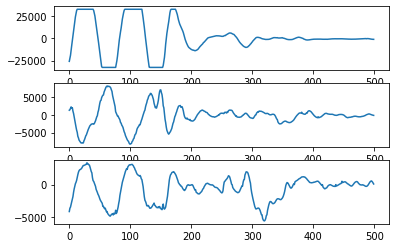

In [69]:
fig, ax = plt.subplots(3)
t = [i for i in range(0,len(strm))]

xd = [d['x'] for d in strm]
yd = [d['y'] for d in strm]
zd = [d['z'] for d in strm]
ax[0].plot(t,xd)
ax[1].plot(t,yd)
ax[2].plot(t,zd)
